# Average Middle Atmosphere Forcings

In [39]:
import sys, os, glob
import string
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)

In [3]:
import pylab as plt
import seaborn as sns
import importlib

sns.set_context('talk')

colors = plt.rcParamsDefault["axes.prop_cycle"].by_key()["color"]
ora = colors.pop(1)
colors.insert(2, ora)

myPara = {'figure.figsize': (14,7), 'lines.linewidth': 3, 'legend.frameon' : False,
          'axes.spines.right': False,
          'axes.spines.top': False,
          'axes.titleweight': 'bold',
          "axes.prop_cycle": plt.cycler(color=colors)
         }
                            
plt.rcParams.update( myPara )



In [4]:
for pname in plt.rcParams:
    if 'linewidth' in pname:
        print( pname, plt.rcParams[pname])

axes.linewidth 1.875
boxplot.boxprops.linewidth 1.0
boxplot.capprops.linewidth 1.0
boxplot.flierprops.linewidth 1.0
boxplot.meanprops.linewidth 1.0
boxplot.medianprops.linewidth 1.0
boxplot.whiskerprops.linewidth 1.0
contour.linewidth None
grid.linewidth 1.5
hatch.linewidth 1.0
lines.linewidth 3.0
patch.linewidth 1.5


## Open Data

*Data Description*:

* ensembles are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_gfas2020_injtrp+1_pcb_ao_ens`
    * ensemble data two subdirs as hierachical structure
    
* nudged data are here: `/work/bb1262/data/echam-ham/wifi-aus/wifiaus_ham_long_nu_gfas2020_injtrp+1_pcb_ao`


In [5]:
sys.path.append('../tools')

import importlib
import reader, plot, analysis
importlib.reload( reader )
importlib.reload( plot )
importlib.reload( analysis )
from analysis import ens_stat


In [6]:
input_dir = '/work/bb1262/work_archive/bm0834/data/wifi-aus/statistics/'

dset = xr.open_dataset( f'{input_dir}/radfluxes-by-latitude.nc')

## Plotting

### Radiation Vars 

In [23]:

vlist = ['srad0', 'trad0', 'F_net_TOA',
#          'F_sw_atm', 'F_lw_atm', 'F_net_atm', 
         'F_sw_MA', 'F_lw_MA', 'F_net_MA',
         'F_sw_LA', 'F_lw_LA', 'F_net_LA',
         'srads', 'trads', 'F_net_surf']

ylabels = []
for layer in ['TOA', 'MATM', 'LATM', 'SURF']:
    for component in ['sw', 'lw', 'net']:
        ylabels += ['$F_\mathrm{%s, %s}$ \n (W m${}^{-2}$)' % (component, layer),]

titles = ['']*12

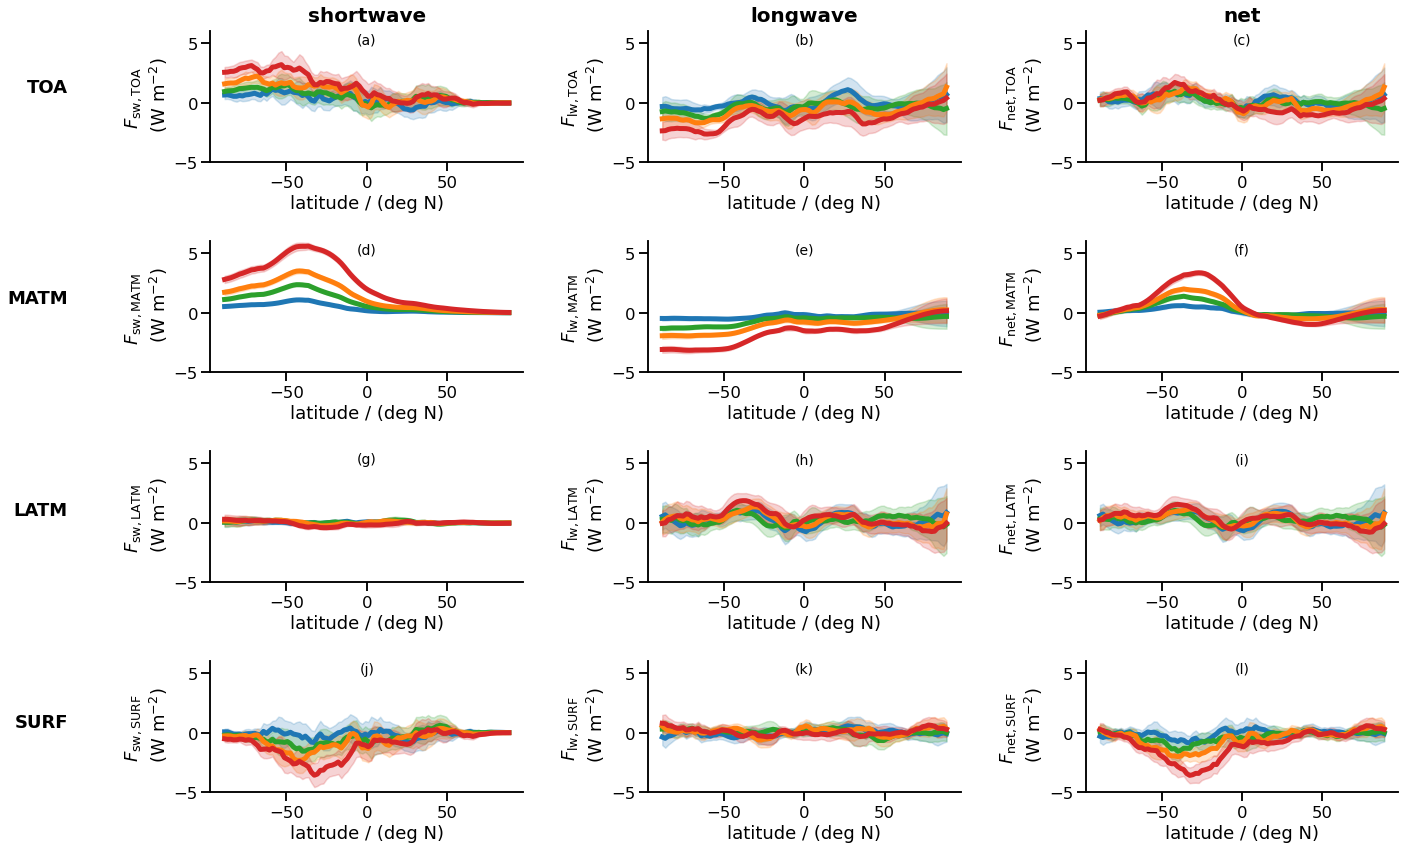

In [48]:
fig, axs = plt.subplots( ncols = 3, nrows = 4, figsize = (22,14))
plt.subplots_adjust(left = 0.15, wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

abc = string.ascii_lowercase


for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff(dset[vlist[i]], ylabel = ylabels[i], title = titles[i])
    axs[i].set_ylim(-5,6)
    axs[i].text(0, 5, '(%s)' % abc[i], fontsize = 14, ha = 'center')

for l, layer in enumerate( ['TOA', 'MATM', 'LATM', 'SURF']) :
    plt.figtext(0.06, 0.82 - 0.21*l, layer, fontsize = 18, fontweight = 'bold', ha = 'right' )
        
for i, component in enumerate(['shortwave', 'longwave', 'net']):
    axs[i].set_title(component, fontweight = 'bold', fontsize = 20, pad = 10)

plt.savefig('../pics/radfluxes-by-latitude.png', dpi = 600)

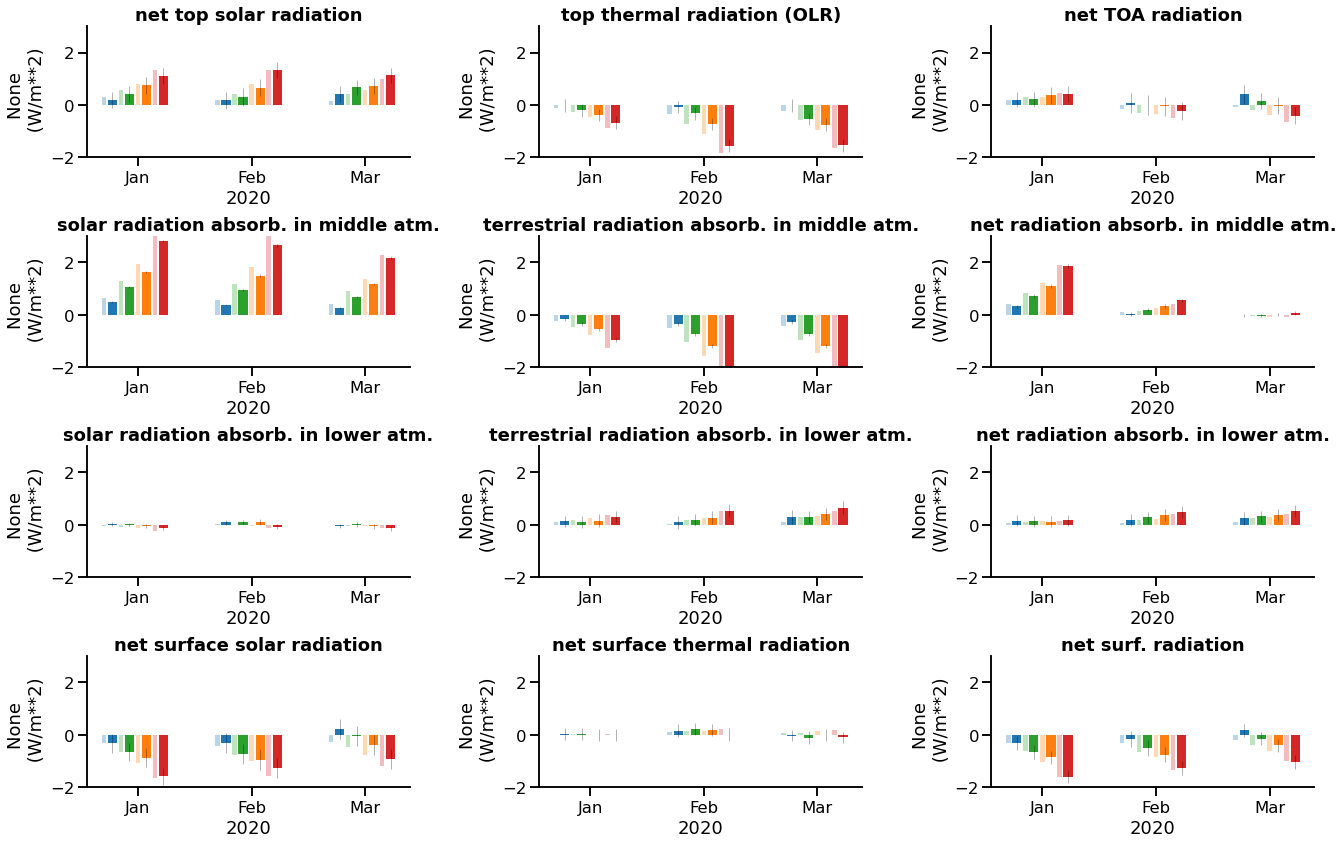

In [8]:
fig, axs = plt.subplots( ncols = 3, nrows = 4, figsize = (22,14))
plt.subplots_adjust( wspace = 0.4, hspace = 0.6)
axs = axs.flatten()

vlist = ['srad0', 'trad0', 'F_net_TOA',
#          'F_sw_atm', 'F_lw_atm', 'F_net_atm', 
         'F_sw_MA', 'F_lw_MA', 'F_net_MA',
         'F_sw_LA', 'F_lw_LA', 'F_net_LA',
         'srads', 'trads', 'F_net_surf']

for i in range(len(vlist)):
    plt.sca(axs[i])
    plot.plot_diff_ts(dset[vlist[i]], method = 'globalmean', style = 'bar', add_nudged = True)
    axs[i].set_ylim(-2,3)

plt.savefig('../pics/radfluxes-by-time.png', dpi = 600)

**Take-aways**

* radiation:
    - no significant change in the SW radiation part that is unaffected by aerosols


* cloud cover:
    - total CC: reduces
    - low & mid-level CC: highly uncertain
    - high CC: reduces and is mainly responsible